In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import sys
sys.path.append('../')
# Scientific 

import numpy as np
import random

import Train
from tqdm import tqdm
import matplotlib.pyplot as plt

# Machine learning

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, classification_report
from keras.utils import to_categorical

import temperature_scaling
from scipy.special import softmax
import xgboost

Using TensorFlow backend.


In [33]:
# Read in data wrt kic and fill etc.
NDAYS = 27
dataset = 'KIC'
accounting_for_TESS = False #True
df = pd.read_csv('../Colours_New_Gaps_output_data_noise_'+str(dataset)+'_'+str(NDAYS)+'_APOKASC.csv')
bad_kics = [10403036, 9846355, 5004660, 4936438, 6450613, 10597648, 5395942]
df = df[~df.KIC.isin(bad_kics)] 
print(np.shape(df))
# Set up training class
CLP = Train.Train(df, dataset, NDAYS)
# Preprocess
CLP.preprocess_data()
# Set up data for training
CLP.setup_for_training(features=['KIC', 'numax', 'var', 'zc', 'hoc', 'abs_k_mag'])

# Extract the train and valid (used for validation) dataframes from the train_df
train_features, valid_features, y_train, y_valid = CLP.X_train.drop(['KIC', 'numax'], axis=1), CLP.X_test.drop(['KIC', 'numax'], axis=1), CLP.Y_train, CLP.Y_test

(393409, 17)
['KIC', 'numax', 'var', 'zc', 'hoc', 'abs_k_mag']


/home/kuszi/.envs/venv/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kuszi/.envs/venv/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [34]:
param_full = {'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'eta': 0.1,
                'gamma': 7.5,
                'max_depth': 3,
                'min_child_weight': 4,
                'subsample': 0.7,
                'colsample': 0.7,
                'silent': 1,
                'nthread': 4,
                'num_class': 5,
                'seed': 0}
param_180 = {'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'eta': 0.375,
                'gamma': 7.5,
                'max_depth': 6,
                'min_child_weight': 1.0,
                'subsample': 0.5,
                'colsample': 0.5,
                'silent': 1,
                'nthread': 4,
                'num_class': 5,
                'seed': 0}

param_80 = {'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'eta': 0.275,
                'gamma': 7.5,
                'max_depth': 10,
                'min_child_weight': 2.0,
                'subsample': 0.85,
                'colsample': 0.85,
                'silent': 1,
                'nthread': 4,
                'num_class': 5,
                'seed': 0}

param_27 = {'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'eta': 0.025,
                'gamma': 7.5,
                'max_depth': 8,
                'min_child_weight': 3.0,
                'subsample': 0.5,
                'colsample': 0.85,
                'silent': 1,
                'nthread': 4,
                'num_class': 5,
                'seed': 0}

In [35]:
if NDAYS == -1:
    param = param_full
    title = '4 years'
elif NDAYS == 180:
    param = param_180
    title = '180 days'
elif NDAYS == 80:
    param = param_80
    title = '80 days'    
elif NDAYS == 27:
    param = param_27
    title = '27 days'
else:
    sys.exit()
bst = xgboost.Booster(param)
#bst.load_model('../Clumpiness-package/Code/-1random.model')
#bst.load_model('/mnt/seismo/scratch/seismo/kuszlewicz/Clumpiness-refactor/Code/'+str(NDAYS)+'.model')
#best_iter = np.loadtxt('/mnt/seismo/scratch/seismo/kuszlewicz/Clumpiness-refactor/Code/best_iter_'+str(NDAYS)+'.txt')
bst.load_model('../'+str(NDAYS)+'.model')
best_iter = np.loadtxt('../best_iter_'+str(NDAYS)+'.txt')
print(f"Best iter: {best_iter}")

Best iter: 540.0


In [36]:
if NDAYS == -1:
    df['running_var'] = np.log10(np.abs(df['running_var']))
    df = df[df['running_var'] < 2.5]
df.sample(frac=1).reset_index(drop=True)

predict_df = df[(df['ndata'] < ((180 * 86400.0)/(29.4*60))) | (df['evo'] == 6)]
predict_df = predict_df[predict_df['fill'] > 0.5]
if NDAYS == -1:
    df = df[df['ndata'] > ((180 * 86400.0)/(29.4*60))]
else:
    df = df[df['ndata'] > (((NDAYS/2) * 86400.0)/(29.4*60))]

df = df[df['fill'] > 0.5]
df = df[df['evo'] < 5]
#df = df.drop_duplicates('KIC')

X = df[['KIC', 'numax', 'var', 'zc', 'hoc', 'abs_k_mag', 'mc']]
#X['var'] = X['var']**2
#X['mc'] = X['mc']**2
#X = pd.read_csv('/mnt/seismo/scratch/seismo/kuszlewicz/Clumpiness-refactor/Code/random_feature_test.csv')
X = X.rename(index=str, columns={"var": r"$\log_{10}\sigma^{2}$", "mc": r"$\log_{10}\sigma^{2}_{\mathrm{diff}}$", "hoc": r"$\psi^{2}$", "abs_k_mag": r"$M_{K_{s}}$"})
#plt.hist(X.loc[X['y'] == 0,'rand'], bins=30, histtype='step', density=True);
#plt.hist(X.loc[X['y'] == 1,'rand'], bins=30, histtype='step', density=True);
#plt.hist(np.random.normal(size=len(X.loc[X['y'] == 1,'rand'])), bins=30, histtype='step', density=True);
#plt.hist(X.loc[X['y'] == 2,'rand'], bins=30, histtype='step', density=True);
#plt.hist(X.loc[X['y'] == 3,'rand'], bins=30, histtype='step', density=True);
#plt.hist(X.loc[X['y'] == 4,'rand'], bins=30, histtype='step', density=True);
#y = X['y'].astype(int)
#X = X.drop(['y'], axis=1)
print(X.drop(['KIC', 'numax'], axis=1).head())
y = df['evo'].astype(int)
print(y)
X_train, X_test, Y_train, Y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        stratify=y)
print(np.shape(X_test),np.shape(Y_test))
print(np.shape(X))

    $\log_{10}\sigma^{2}$        zc  $\psi^{2}$  $M_{K_{s}}$  \
55            1059.945783  0.037051    1.543675    -3.428712   
56             912.874195  0.040885    1.691732    -3.404508   
57             848.440049  0.044826    1.480001    -3.005549   
58             980.103336  0.038769    1.598494    -3.411025   
59             961.550072  0.050105    1.509057    -3.257199   

    $\log_{10}\sigma^{2}_{\mathrm{diff}}$  
55                             111.415152  
56                             114.293041  
57                             109.221772  
58                             109.939907  
59                             111.305115  
55        1
56        1
57        1
58        1
59        1
         ..
393755    4
393756    4
393757    4
393758    4
393759    4
Name: evo, Length: 355454, dtype: int64
(106637, 7) (106637,)
(355454, 7)


In [37]:
xg_train = xgboost.DMatrix(X_train.drop(['KIC', 'numax'], axis=1))#, label=Y_train.values)
xg_test = xgboost.DMatrix(X_test.drop(['KIC', 'numax'], axis=1))#, label=Y_test.values)
probs_train = bst.predict(xg_train, ntree_limit=best_iter)
probs_test = bst.predict(xg_test, ntree_limit=best_iter)

In [38]:
full_preds = np.c_[probs_test[:,:3].sum(axis=1), probs_test[:,3:]]

In [39]:
#print(predictions)
full_valid = CLP._create_full_class(Y_test)
full_pred = CLP._create_full_class(np.argmax(probs_test, axis=1))
# TODO: Add the importance for the selected features
#print("Score {0}".format(loss))
print("Accuracy {}".format(accuracy_score(Y_test, np.argmax(probs_test, axis=1))))
print("Full accuracy {}".format(accuracy_score(full_valid, full_pred)))
print(classification_report(Y_test, np.argmax(full_preds, axis=1)))
print(classification_report(full_valid, full_pred))

Accuracy 0.9081932162382663
Full accuracy 0.9223909149732269
              precision    recall  f1-score   support

           0       0.18      0.99      0.31      7738
           1       0.00      0.00      0.00      6581
           2       0.00      0.00      0.00     31772
           3       0.00      0.00      0.00     32499
           4       0.00      0.00      0.00     28047

    accuracy                           0.07    106637
   macro avg       0.04      0.20      0.06    106637
weighted avg       0.01      0.07      0.02    106637



/home/kuszi/.envs/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.95      0.86      0.91     46091
           1       0.83      0.94      0.88     32499
           2       0.99      0.99      0.99     28047

    accuracy                           0.92    106637
   macro avg       0.93      0.93      0.93    106637
weighted avg       0.93      0.92      0.92    106637



In [40]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def find_nearest(array, value):
    #https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def compute_ROC(Y_test, yprob, class_names=None):
    if class_names is None:
        class_names = ['LLRGB', 'HLRGB', 'ConfRGB', 'CHeB', 'Noise']
    colours = ['C'+str(i) for i in range(len(class_names))]
    assert len(class_names) == np.shape(yprob)[1]
    # Binarize Labels
    y = label_binarize(Y_test, classes=np.linspace(0, len(class_names)-1, len(class_names)).astype(int))
    # Compute auc/roc etc.
    fpr = dict()
    tpr = dict()
    J = dict()
    roc_auc = dict()
    thresholds = dict()
    n_classes = len(class_names)
    for i in range(n_classes):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y[:,i], yprob[:,i])
        J[i] = tpr[i] - fpr[i]
        roc_auc[i] = auc(fpr[i], tpr[i])

    #print(thresholds)
    best_thresholds = []
    for i in range(n_classes):
        idx = np.argmax(J[i])
        best_threshold = thresholds[i][idx]
        print(f"Best threshold for class {i}: {best_threshold} with J of {np.max(J[i])}")
        best_thresholds = np.append(best_thresholds, best_threshold)
        plt.plot(fpr[i], tpr[i], lw=2, color=colours[i],
        label=r'{} (AUC = {:0.3f})'.format(class_names[i], roc_auc[i]))
        cond = find_nearest(thresholds[i], 1/3) #(abs(thresholds[i]-(1/3)) < 5e-3)
        #print(fpr[i][cond], tpr[i][cond])
        plt.scatter(fpr[i][idx], tpr[i][idx], marker='o', color=colours[i])
        #plt.axvline(fpr[i][cond], color=colours[i], linestyle='--')
        #break
    plt.plot([0,1], [0,1], 'k--', lw=2)
    plt.xlim(0.0, 1)
    plt.ylim(0, 1.05)
    plt.xlabel(r'False Positive Rate', fontsize=18)
    plt.ylabel(r'True Positive Rate', fontsize=18)
    plt.legend(loc='lower right')
    return best_thresholds

Best threshold for class 0: 0.39078980684280396 with J of 0.8354921545719622
Best threshold for class 1: 0.3033811151981354 with J of 0.8677041894235471
Best threshold for class 2: 0.2866983413696289 with J of 0.9927361694639294
(106637,)


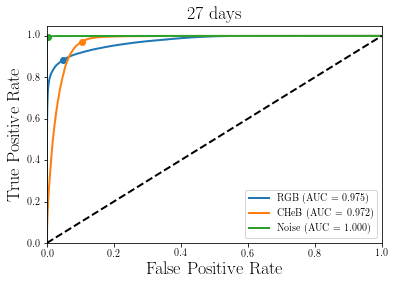

In [41]:
best_thresholds = compute_ROC(full_valid, full_preds, class_names=['RGB', 'CHeB', 'Noise'])
print(np.shape(full_valid))
plt.title(title, fontsize=18)
plt.savefig('ROC_'+str(NDAYS)+'.pdf', bbox_inches='tight')

In [70]:
# Recompute accuracy using those new thresholds
#full_preds[full_preds[:,1] > best_1]
new_pred = np.zeros(len(full_preds))+3
for i in range(len(full_preds)):
    idx, max_prob = np.argmax(full_preds[i,:]), np.max(full_preds[i,:])
    if max_prob > best_thresholds[idx]:
        new_pred[i] = int(idx)

In [71]:
new_pred#, full_valid
print(f"New accuracy is {accuracy_score(new_pred[new_pred < 3], full_valid[new_pred < 3])}")
print(f"Fraction of stars 'unclassified': {len(new_pred[new_pred == 3])}")

New accuracy is 0.929612188365651
Fraction of stars 'unclassified': 0


In [30]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.preprocessing import label_binarize
# Use label_binarize to be multi-label like settings
Y_test = label_binarize(full_valid, classes=[0, 1, 2])
n_classes = Y_test.shape[1]

# For each class
precision = dict()
recall = dict()
average_precision = dict()
thresholds = dict()
fscore = dict()
n_classes = 3
for i in range(n_classes):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(Y_test[:, i],
                                                        full_preds[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], full_preds[:, i])
    fscore[i] = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])
    ix = np.argmax(fscore)
    best_threshold = thresholds[i][ix]
    print(f"Best threshold for class {i}: {best_threshold} with f-score of {np.max(fscore[i])}")

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    full_preds.ravel())
average_precision["micro"] = average_precision_score(Y_test, full_preds,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Best threshold for class 0: 0.05274786800146103 with f-score of 0.91365171249397
Best threshold for class 1: 0.01410063449293375 with f-score of 0.8929266709928617
Best threshold for class 2: 0.008638545870780945 with f-score of 0.9929328621908127
Average precision score, micro-averaged over all classes: 0.98


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.98')

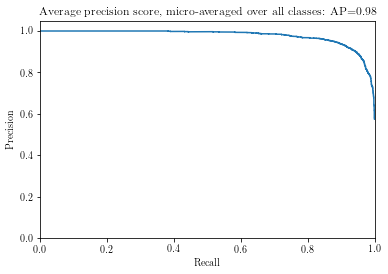

In [31]:
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

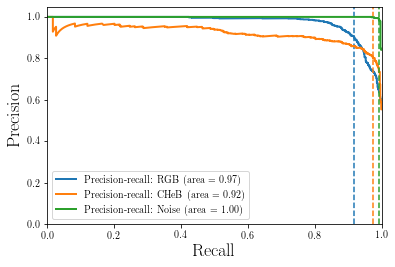

In [32]:
from itertools import cycle
# setup plot details
#colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
colours = ['C0', 'C1', 'C2']
class_names = ['RGB', 'CHeB', 'Noise']

#plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
#for f_score in f_scores:
#    x = np.linspace(0.01, 1)
#    y = f_score * x / (2 * x - f_score)
#    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
#    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

#lines.append(l)
#labels.append('iso-f1 curves')
#l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
#lines.append(l)
#labels.append('micro-average Precision-recall (area = {0:0.2f})'
#              ''.format(average_precision["micro"]))
for i in range(n_classes):
    l, = plt.plot(recall[i], precision[i], color=colours[i], lw=2)
    lines.append(l)
    labels.append('Precision-recall: {0} (area = {1:0.2f})'
                  ''.format(class_names[i], average_precision[i]))
    idx = find_nearest(thresholds[i], 1/3)
    plt.axvline(recall[i][idx], color=colours[i], linestyle='--')

    
#fig = plt.gcf()
#fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel(r'Recall', fontsize=18)
plt.ylabel(r'Precision', fontsize=18)
#plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels)#, loc=(0, -.38), prop=dict(size=14))


plt.show()

In [33]:
class_names = ['RGB', 'CHeB', 'Noise']
for i in range(len(class_names)):
    plt.plot(thresholds, pr[:,i], label=class_names[i])
plt.step(thresholds, nsamples)
plt.axvline(1/3, color='r', linestyle='--', label=r'$1/C$ decision threshold')
plt.xlabel(r'Decision Threshold')
plt.ylabel('Precision')
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.legend(loc='best')
#plt.savefig('Precision_'+str(NDAYS)+'.pdf', bbox_inches='tight')
plt.show()
for i in range(len(class_names)):
    plt.plot(thresholds, rc[:,i], label=class_names[i])
plt.axvline(1/3, color='r', linestyle='--', label=r'$1/C$ decision threshold')
plt.xlabel(r'Decision Threshold')
plt.ylabel('Recall')
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.legend(loc='best')
#plt.savefig('Recall_'+str(NDAYS)+'.pdf', bbox_inches='tight')
plt.show()
colour = ['C0', 'C1', 'C2']
for i in range(len(class_names)):
    plt.plot(pr[:,i], rc[:,i], label=class_names[i])
    idx = find_nearest(thresholds, 1/3)
    plt.axvline(pr[:,i][idx], color=colour[i], linestyle='--')
plt.xlabel(r'Precision')
plt.ylabel('Recall')
plt.xlim(0.6, 1)
plt.ylim(0.7, 1)
plt.legend(loc='best')
#plt.savefig('Precision_Recall_'+str(NDAYS)+'.pdf', bbox_inches='tight')
plt.show()
for i in range(len(class_names)):
    plt.plot(rc[:,i], pr[:,i], label=class_names[i])
    idx = find_nearest(thresholds, 1/3)
#    plt.axvline(pr[:-5,i][idx], color=colour[i], linestyle='--')
plt.ylabel(r'Precision')
plt.xlabel('Recall')
plt.xlim(0.6, 1)
plt.ylim(0.7, 1)
plt.legend(loc='best')
#plt.savefig('Precision_Recall_'+str(NDAYS)+'.pdf', bbox_inches='tight')
plt.show()

NameError: name 'pr' is not defined